In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import os
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder,LabelEncoder,MaxAbsScaler,RobustScaler
from sklearn.metrics import f1_score, accuracy_score
from imblearn.over_sampling import BorderlineSMOTE,ADASYN,SMOTE,SVMSMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from math import ceil
from numpy.random import RandomState
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
from sklearn.feature_selection import SelectKBest,f_classif,mutual_info_classif
from sklearn.model_selection import GridSearchCV  

from sklearn.tree import DecisionTreeClassifier


### Functions

In [8]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.xticks(rotation="vertical")
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'),labelspacing =1)
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    plt.xticks(rotation="vertical")
    plt.show()
    

In [9]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [10]:
def best_scale(model,X_train,y_train,X_test,y_test):
    standard=StandardScaler().fit(X_train).transform(X_train)
    standardTest=StandardScaler().fit(X_test).transform(X_test)

    minMax=MinMaxScaler().fit(X_train).transform(X_train)
    minMaxTest=MinMaxScaler().fit(X_test).transform(X_test)

    maxAbs=MaxAbsScaler().fit(X_train).transform(X_train)
    maxAbsTest=MaxAbsScaler().fit(X_test).transform(X_test)
        
    robust=RobustScaler().fit(X_train).transform(X_train)
    robustTest=RobustScaler().fit(X_test).transform(X_test)

    sclares=[standard,minMax,maxAbs,robust,X_train]
    sclaresTest=[standardTest,minMaxTest,maxAbsTest,robustTest,X_test]
    
    f_score=[]
    
    for i in range(len(sclares)):
        model.fit(sclares[i],y_train)
        y_pred=model.predict(sclaresTest[i])
        f_score.append(f1_score(y_pred,y_test,average="weighted"))
        

    return pd.DataFrame(f_score,index=["Standard","MinMax","MaxAbs","Robust","No Scaler"], columns=["F1 Score"])
    

### Reading the Data

In [18]:
df = pd.read_excel("../train.xlsx")
df.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [19]:
original = df.copy()

In [20]:
df.replace("?", np.nan, inplace=True)
df.isna().sum()

CITIZEN_ID                   0
Name                         0
Birthday                     0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64

In [21]:
df.isna().sum()/len(df)*100

CITIZEN_ID                0.000000
Name                      0.000000
Birthday                  0.000000
Native Continent          0.000000
Marital Status            0.000000
Lives with                0.000000
Base Area                 1.763393
Education Level           0.000000
Years of Education        0.000000
Employment Sector         5.642857
Role                      5.674107
Working Hours per week    0.000000
Money Received            0.000000
Ticket Price              0.000000
Income                    0.000000
dtype: float64

In [22]:
df[["Gender","Name"]]=df["Name"].str.split(" ", n=1,expand=True)
df["Gender"].replace(["Mr."],"M",inplace=True)
df["Gender"].replace(["Miss","Mrs."],"F",inplace=True)

In [23]:
df[["Mouth","Year"]]=df['Birthday'].str.split(",",expand=True)
df["Year"]=df["Year"].astype(int)
df["Age"] = 2046 - df["Year"]

In [24]:
df.set_index("CITIZEN_ID",inplace=True)

In [25]:
df.drop(["Name","Mouth","Year","Birthday"],inplace=True,axis=1)

### New variables

In [26]:
#df["Working Hours per week/age"]=df["Working Hours per week"]/df["Age"]*100
#df["Years of Education/age"]=df["Years of Education"]/df["Age"]
#df["Working Hours per week/Years of Education"]=df["Working Hours per week"]/df["Years of Education"]

In [27]:
df

,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income,Gender,Age
CITIZEN_ID,,,,,,,,,,,,,,
12486,Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1,M,43
12487,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1,M,40
12488,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1,M,37
12489,Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1,M,61
12490,Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1,M,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34881,Europe,Divorced,Children,Northbury,Professional School,12,Private Sector - Services,Cleaners & Handlers,40,0,0,0,F,23
34882,Europe,Single,Children,Northbury,Professional School,12,Private Sector - Services,Other services,35,0,0,0,M,21
34883,Europe,Single,Other Family,Northbury,Masters,17,Public Sector - Others,Professor,40,2674,0,0,F,24


In [28]:
categorical = df.select_dtypes(include="object").columns.to_list()
numerical = df.columns.drop(categorical).drop("Income").to_list()

### Visualize

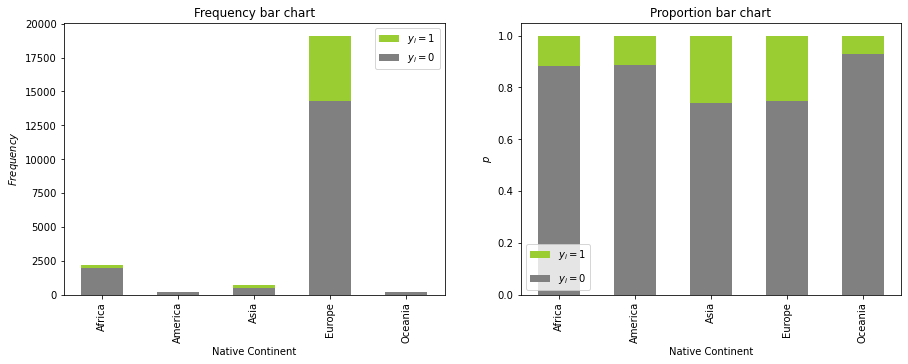

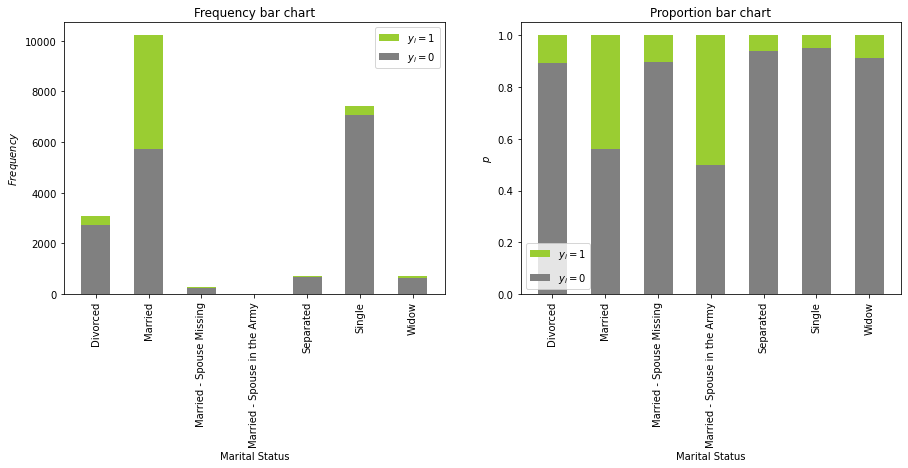

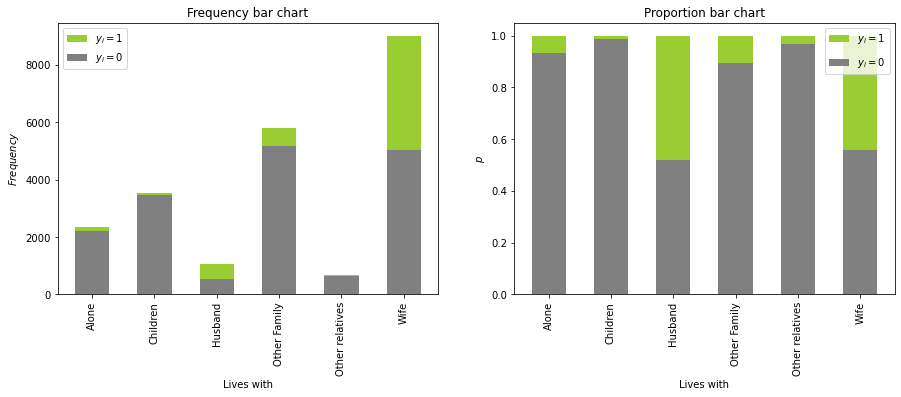

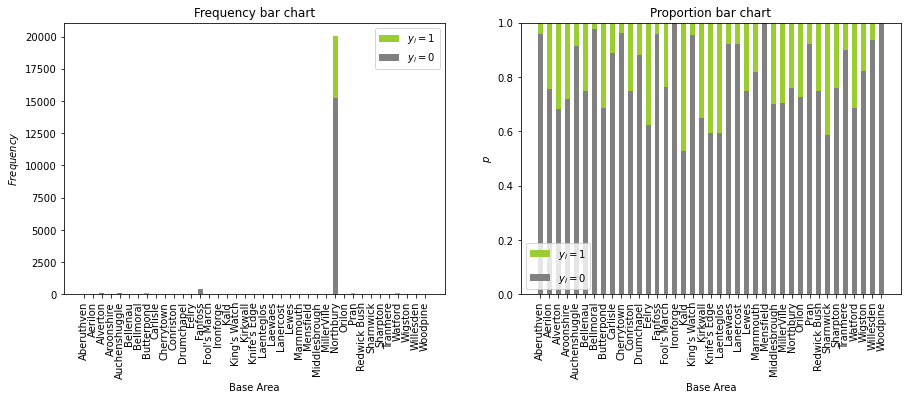

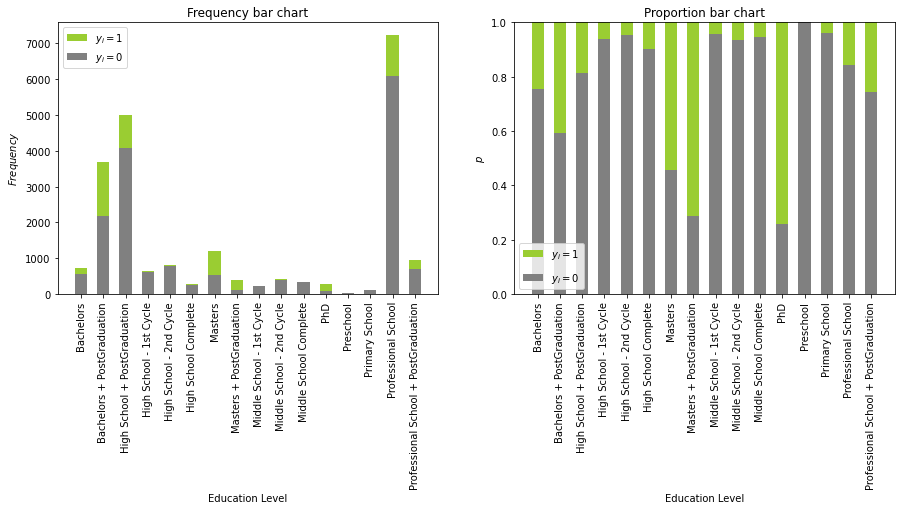

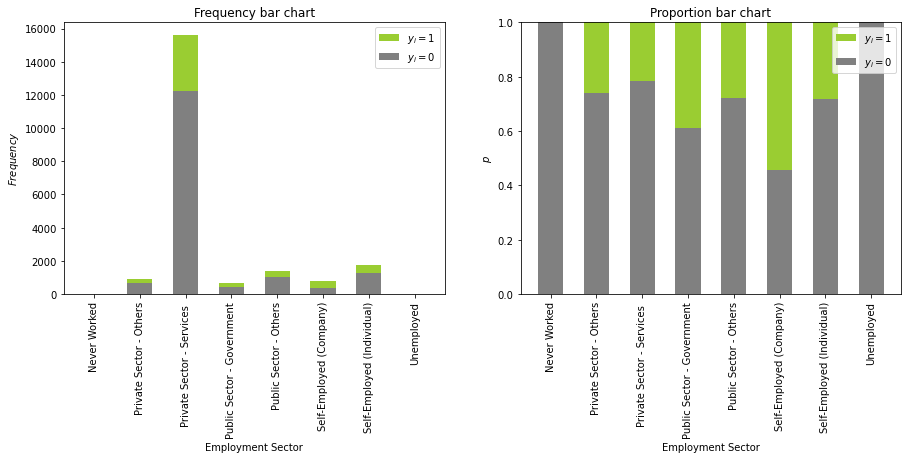

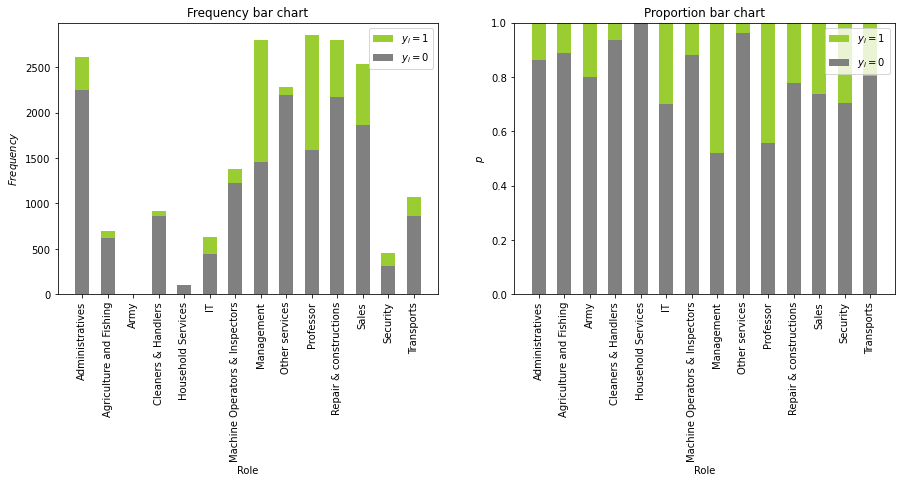

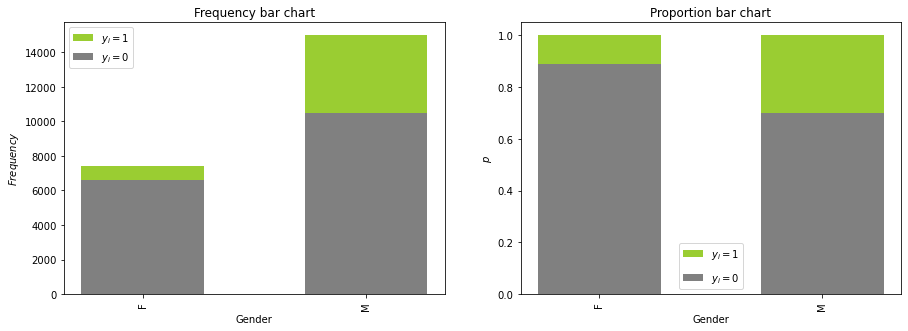

In [29]:
for i in categorical:   
    bar_charts_categorical(df, i, "Income")

In [30]:
df["Marital Status"].replace(["Married - Spouse in the Army" ],"Married",inplace=True)
df["Marital Status"].replace(["Married - Spouse Missing" ,"Widow","Divorced"],"Other",inplace=True)

In [31]:
df["Lives with"].replace(["Husband","Wife" ],"Partner",inplace=True)
df["Lives with"].replace(["Other relatives","Children"],"Other",inplace=True)

In [32]:
#tem demasiadas categorias
df.drop(["Base Area"],axis=1,inplace=True)
categorical.remove("Base Area")

In [33]:
df["Education Level"].replace(["High School - 2nd Cycle","High School - 1st Cycle","Middle School Complete","Primary School","Preschool","High School Complete","High School - 1st Cycle","High School - 2nd Cycle","Professional School","Middle School - 1st Cycle","Middle School - 2nd Cycle"],"No college degree",inplace=True)
df["Education Level"].replace(["High School + PostGraduation","Bachelors","Professional School + PostGraduation"],"1 Degree",inplace=True)
df["Education Level"].replace(["Bachelors + PostGraduation","Masters"],"2 Degrees",inplace=True)
df["Education Level"].replace(["Masters + PostGraduation","PhD"],"3 Degrees",inplace=True)

In [34]:
df["Employment Sector"].replace(["Private Sector - Services ","Private Sector - Others"],"Private Sector",inplace=True)
df["Employment Sector"].replace(["Public Sector - Others","Public Sector - Government"],"Public Sector",inplace=True)
df["Employment Sector"].replace(["Unemployed","Never Worked"],"Other",inplace=True)

In [35]:
df["Role"].replace(["Cleaners & Handlers","Machine Operators & Inspectors","Administratives","Agriculture and Fishing","Household Services"],"Other services",inplace=True)

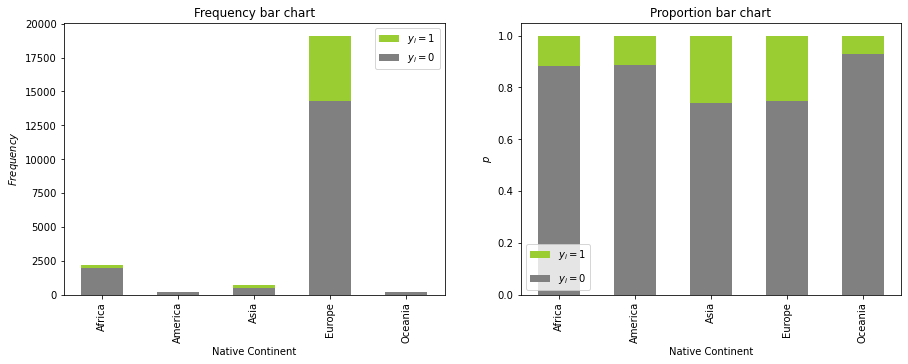

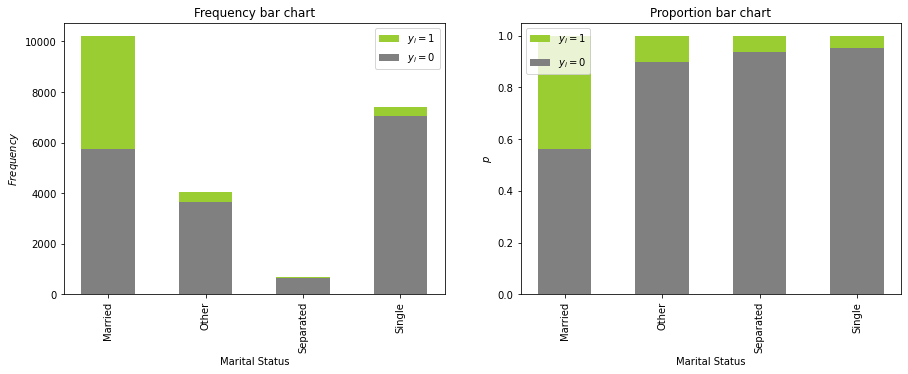

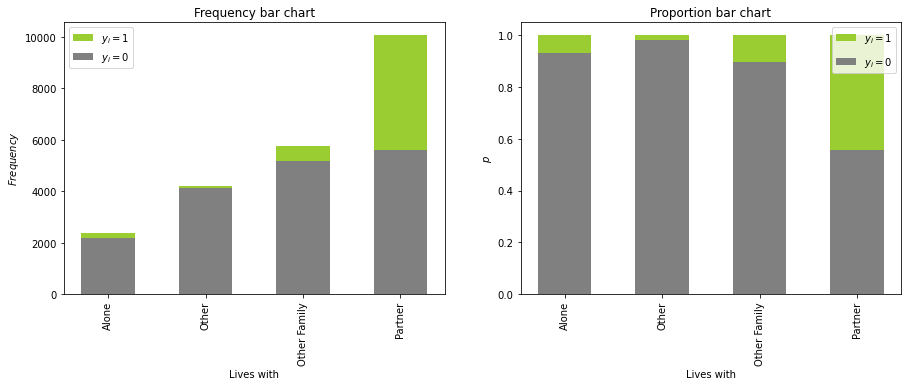

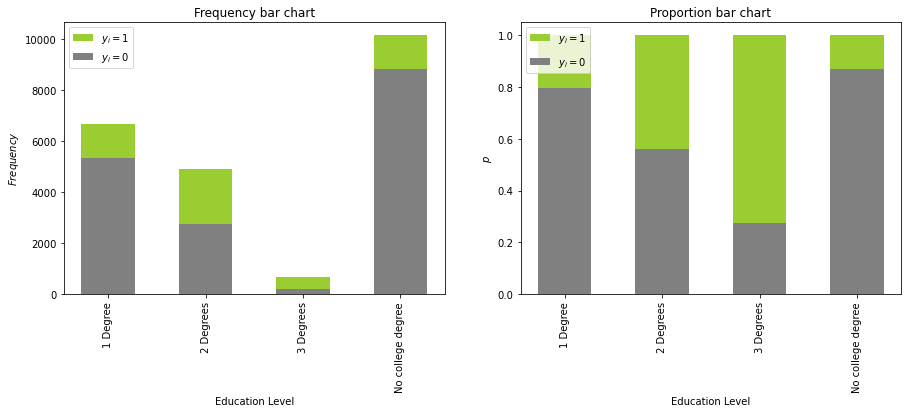

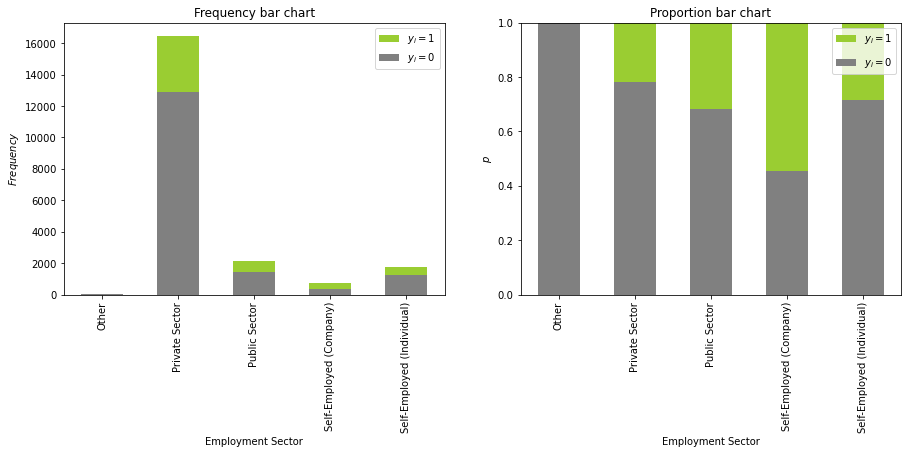

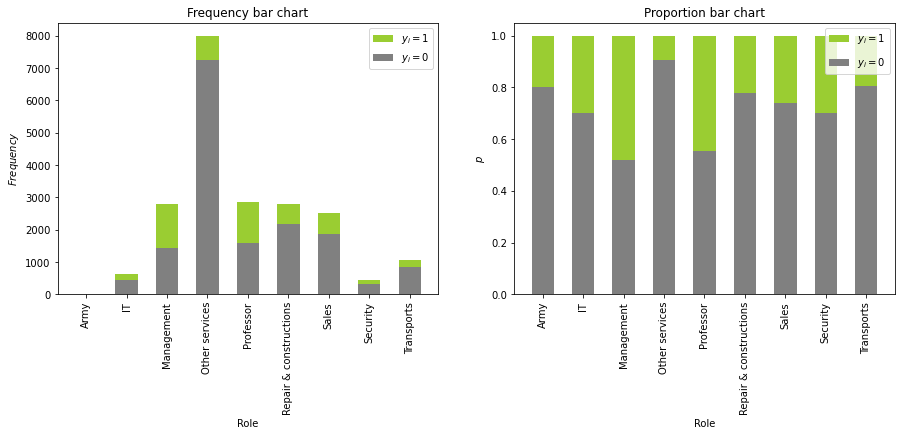

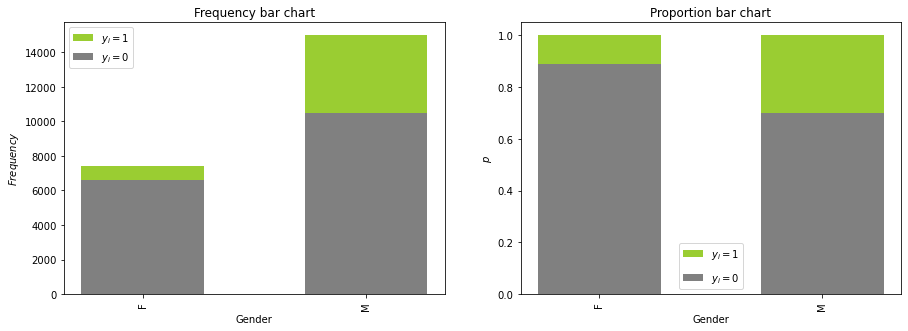

In [36]:
for i in categorical:   
    bar_charts_categorical(df, i, "Income")

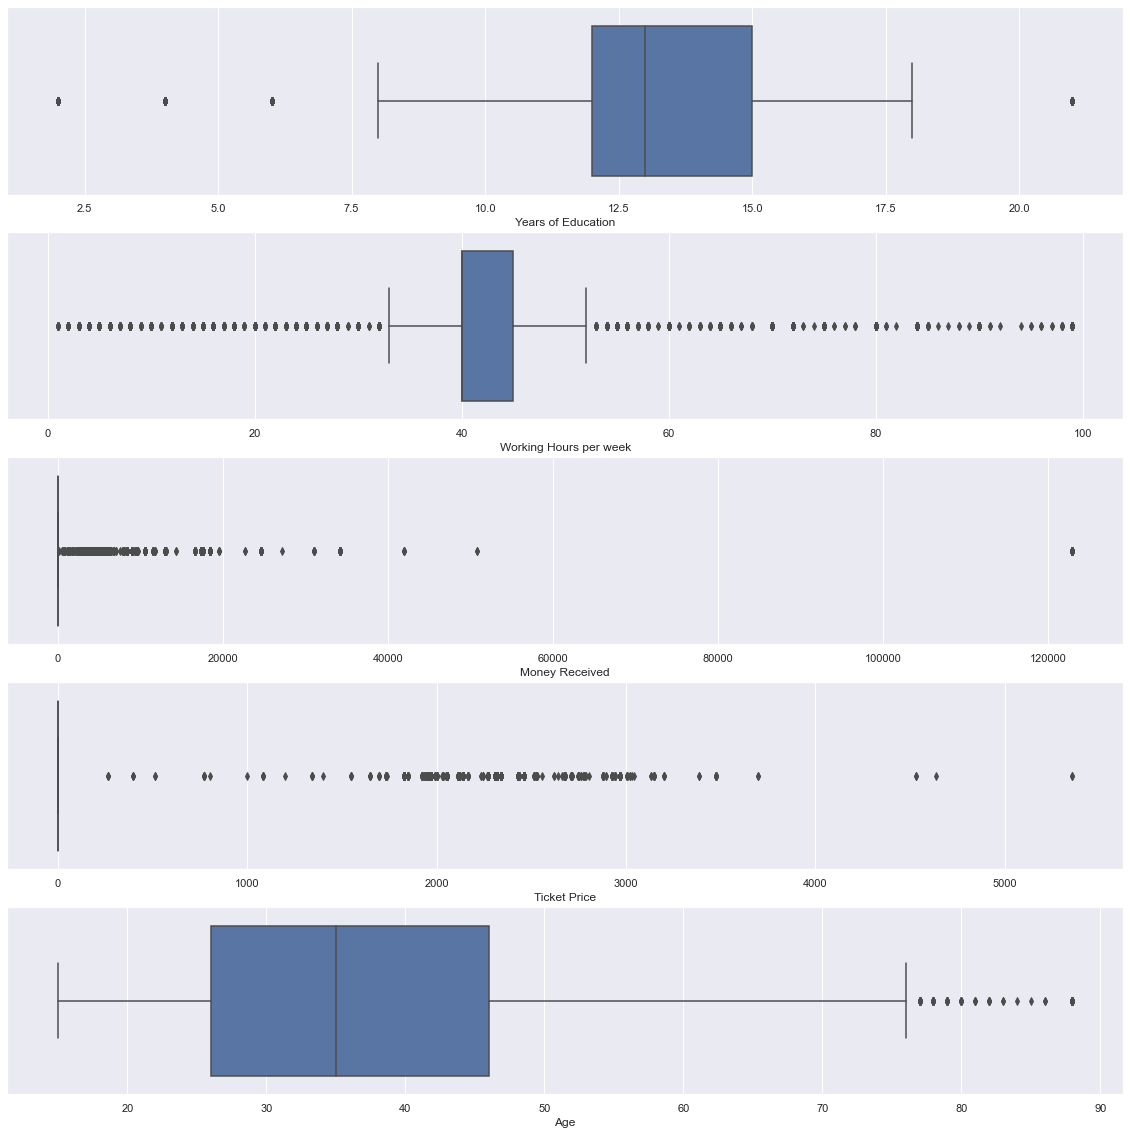

In [37]:
sns.set()
fig, axes = plt.subplots(len(numerical), ceil(len(numerical) / len(numerical)), figsize=(20, 20))
for ax, feat in zip(axes.flatten(), numerical):
    sns.boxplot(x=df[feat], ax=ax) 
plt.show()

### Fill Missing Values

In [38]:
modes = df[categorical].mode().loc[0]
df.fillna(modes,inplace=True)

### Removing Outliers

In [39]:
filters = (
    (df["Working Hours per week"]>7)
    & 
    (df["Years of Education"]<20)
    &
    (df["Ticket Price"]<4000)
    &
    (df["Money Received"]<120000))

df1=df[filters]
print('Percentage of data kept after removing outliers:', np.round(df1.shape[0] / original.shape[0], 4))
#df=df1.copy()

Percentage of data kept after removing outliers: 0.9735


### Separating X and Y

In [40]:
X=df.drop(["Income","Native Continent"],axis=1)
y=df.loc[:,"Income"]
categorical=X.select_dtypes(include="object").columns.to_list()

### One Hot Encoder

In [41]:
df_ohc = X.copy()
categorical=X.select_dtypes(include="object").columns.to_list()
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[categorical])
ohc_feat_names = ohc.get_feature_names(categorical)
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
# Reassigning df to contain ohc variables
df_ohc = pd.concat([ohc_df,df_ohc.drop(columns=categorical)], axis=1)
X=df_ohc.copy()
X.head()

,Marital Status_Other,Marital Status_Separated,Marital Status_Single,Lives with_Other,Lives with_Other Family,Lives with_Partner,Education Level_2 Degrees,Education Level_3 Degrees,Education Level_No college degree,Employment Sector_Private Sector,...,Role_Repair & constructions,Role_Sales,Role_Security,Role_Transports,Gender_M,Years of Education,Working Hours per week,Money Received,Ticket Price,Age
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,13,40,0,2273,43
12487,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,12,40,0,0,40
12488,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,12,46,0,2321,37
12489,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,11,37,5395,0,61
12490,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,21,45,0,0,31


## Data Splitting

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) 

### Model

In [43]:
rf = RandomForestClassifier(class_weight={1:2},criterion="gini",n_estimators=100,max_features=15,random_state=100,n_jobs=-1,max_depth=16,min_samples_leaf=8)
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight={1: 2}, max_depth=16, max_features=15,
                       min_samples_leaf=8, n_jobs=-1, random_state=100)

In [44]:
best_scale(rf,X_train,y_train,X_test,y_test)

,F1 Score
Standard,0.838365
MinMax,0.845683
MaxAbs,0.845475
Robust,0.847388
No Scaler,0.845475


### Feature Selection

In [45]:
importances = rf.feature_importances_
indices = np.argsort(importances)

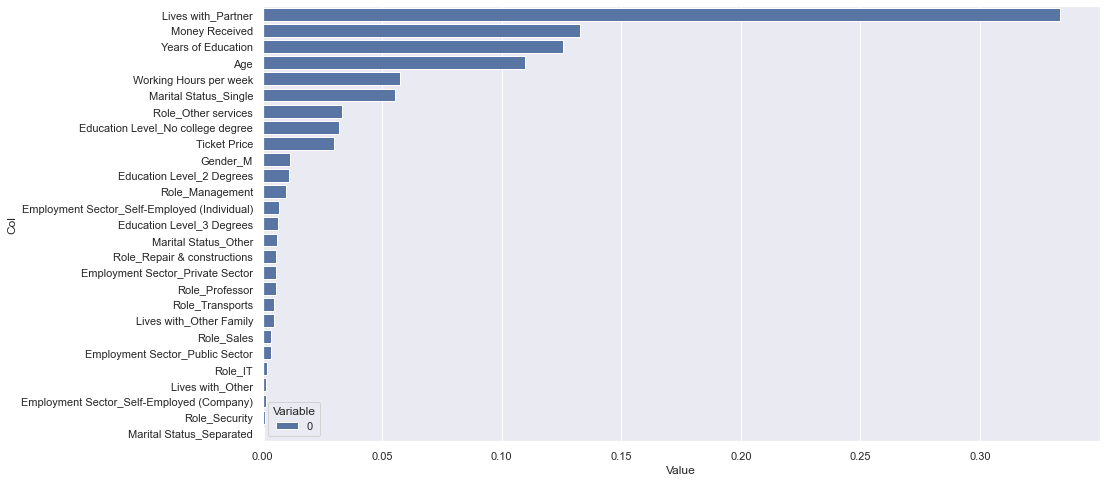

In [46]:
zippy = pd.DataFrame(zip(importances))
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [47]:
#"Role_Repair & constructions","Role_Professor","Employment Sector_Private Sector","Employment Sector_Self-Employed (Individual)"

In [48]:
X_random = X.drop(["Role_Security","Employment Sector_Self-Employed (Company)","Role_IT","Marital Status_Separated","Education Level_3 Degrees","Role_Transports","Role_Sales","Employment Sector_Public Sector","Role_Repair & constructions","Role_Professor","Employment Sector_Private Sector"],axis=1)

In [49]:
X.columns

Index(['Marital Status_Other', 'Marital Status_Separated',
       'Marital Status_Single', 'Lives with_Other', 'Lives with_Other Family',
       'Lives with_Partner', 'Education Level_2 Degrees',
       'Education Level_3 Degrees', 'Education Level_No college degree',
       'Employment Sector_Private Sector', 'Employment Sector_Public Sector',
       'Employment Sector_Self-Employed (Company)',
       'Employment Sector_Self-Employed (Individual)', 'Role_IT',
       'Role_Management', 'Role_Other services', 'Role_Professor',
       'Role_Repair & constructions', 'Role_Sales', 'Role_Security',
       'Role_Transports', 'Gender_M', 'Years of Education',
       'Working Hours per week', 'Money Received', 'Ticket Price', 'Age'],
      dtype='object')

In [50]:
X_random.shape

(22400, 16)

### Scaler

In [51]:
X_random=RobustScaler().fit(X_random).transform(X_random)

## Data Split after feature selection

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_random, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=15, 
                                                    stratify=y)

In [57]:
rf = RandomForestClassifier(class_weight={1:2},criterion="entropy",n_estimators=100,max_features="sqrt",random_state=100,n_jobs=-1,max_depth=12,min_samples_leaf=3)
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight={1: 2}, criterion='entropy', max_depth=12,
                       max_features='sqrt', min_samples_leaf=3, n_jobs=-1,
                       random_state=100)

In [58]:
y_train_pred= rf.predict(X_train)
y_test_pred=rf.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     13671
           1       0.69      0.78      0.73      4249

    accuracy                           0.86     17920
   macro avg       0.81      0.84      0.82     17920
weighted avg       0.87      0.86      0.87     17920

[[12149  1522]
 [  925  3324]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

### Cross-Validation

In [59]:
cv_results = cross_validate(rf, X_train,y_train, cv=10, scoring=["f1_weighted"])
cv_results["test_f1_weighted"].mean()

0.8488810266159537

In [60]:
rf_entropy = RandomForestClassifier(class_weight={1:2},criterion="entropy",n_estimators=100,max_features=16,random_state=100,n_jobs=-1,max_depth=12,min_samples_leaf=3)
rf_entropy.fit(X_train,y_train)
rf_gini = RandomForestClassifier(class_weight={1:2},criterion="gini",n_estimators=100,max_features=16,random_state=100,n_jobs=-1,max_depth=12,min_samples_leaf=3)
rf_gini.fit(X_train,y_train)


RandomForestClassifier(class_weight={1: 2}, max_depth=12, max_features=16,
                       min_samples_leaf=3, n_jobs=-1, random_state=100)

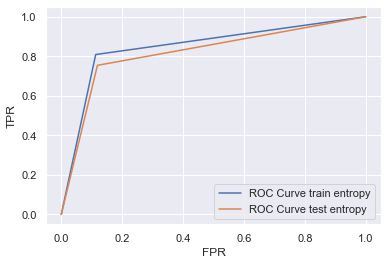

In [61]:
fpr_train_entropy, tpr_train_entropy, thresholds_train_entropy = roc_curve(y_train, rf_entropy.predict(X_train))
fpr_test_entropy, tpr_test_entropy, thresholds_test = roc_curve(y_test, rf_entropy.predict(X_test))
plt.plot(fpr_train_entropy, tpr_train_entropy,label="ROC Curve train entropy")
plt.plot(fpr_test_entropy, tpr_test_entropy,label="ROC Curve test entropy")
fpr_train_gini, tpr_train_gini, thresholds_train_gini = roc_curve(y_train, rf_gini.predict(X_train))
fpr_test_gini, tpr_test_gini, thresholds_test_gini = roc_curve(y_test, rf_gini.predict(X_test))
#plt.plot(fpr_train_gini, tpr_train_gini,label="ROC Curve train gini")
#plt.plot(fpr_test_gini, tpr_test_gini,label="ROC Curve test gini")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [62]:
from sklearn.metrics import auc

def calculate_AUC(interval, x_train, x_test, y_train, y_test, parameter, max_depth = None):
    train_results = []
    test_results = []
    for value in interval:
        if (parameter == 'depth'):          
            dt = DecisionTreeClassifier(max_depth = value)
            dt.fit(x_train, y_train)
        elif (parameter == 'features'):  
            dt = DecisionTreeClassifier(max_features = value, max_depth = max_depth)
            dt.fit(x_train, y_train)
        train_pred = dt.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous train results
        train_results.append(roc_auc)
        y_pred = dt.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous test results
        test_results.append(roc_auc)
    value_train = train_results.index(max(train_results))
    value_test = test_results.index(max(test_results))
    print('The best train value is ',interval[value_train])
    print('The best test value is ',interval[value_test])
    

    import matplotlib.pyplot as plt
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(interval, train_results, 'b', label="Train AUC")
    line2, = plt.plot(interval, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("AUC score")
    plt.xlabel(str(parameter))
    plt.show()

### Grid Search Cv

In [139]:
#max_depth_range=[12,13,15]
#min_samples_leaf_range=[3,7,8,9]
max_features_range=[15,16,21,22]
#n_estimators_range=[100,500,1000]
#random_state_range=[70,100,120,200]
param_grid=dict(max_features=max_features_range)
grid=GridSearchCV(estimator=rf,param_grid=param_grid, cv =5)

In [63]:
#grid.fit(X_train,y_train)
#grid.best_params_

### EXPORT

In [65]:
test = pd.read_excel("../test.xlsx")
original=test.copy()
df.replace("?", np.nan, inplace=True)

test[["Gender","Name"]]=test["Name"].str.split(" ", n=1,expand=True)
test["Gender"].replace(["Mr."],"M",inplace=True)
test["Gender"].replace(["Miss","Mrs."],"F",inplace=True)
test[["Mouth","Year"]]=test['Birthday'].str.split(",",expand=True)
test["Year"]=test["Year"].astype(int)
test["Age"] = 2046 - test["Year"]
test.set_index("CITIZEN_ID",inplace=True)
test.drop(["Name","Mouth","Year","Birthday"],inplace=True,axis=1)

categorical = test.select_dtypes(include="object").columns.to_list()
numerical = test.columns.drop(categorical)

test["Marital Status"].replace(["Married - Spouse in the Army" ],"Married",inplace=True)
test["Marital Status"].replace(["Married - Spouse Missing" ,"Widow","Divorced"],"Other",inplace=True)
test["Lives with"].replace(["Husband","Wife" ],"Partner",inplace=True)
test["Lives with"].replace(["Other relatives","Children"],"Other",inplace=True)
#tem demasiadas categorias
test.drop(["Base Area","Native Continent"],axis=1,inplace=True)
categorical.remove("Base Area")
categorical.remove("Native Continent")

test["Education Level"].replace(["High School - 2nd Cycle","High School - 1st Cycle","Middle School Complete","Primary School","Preschool","High School Complete","High School - 1st Cycle","High School - 2nd Cycle","Professional School","Middle School - 1st Cycle","Middle School - 2nd Cycle"],"No college degree",inplace=True)
test["Education Level"].replace(["High School + PostGraduation","Bachelors","Professional School + PostGraduation"],"1 Degree",inplace=True)
test["Education Level"].replace(["Bachelors + PostGraduation","Masters"],"2 Degrees",inplace=True)
test["Education Level"].replace(["Masters + PostGraduation","PhD"],"3 Degrees",inplace=True)
test["Employment Sector"].replace(["Private Sector - Services ","Private Sector - Others"],"Private Sector",inplace=True)
test["Employment Sector"].replace(["Public Sector - Others","Public Sector - Government"],"Public Sector",inplace=True)
test["Employment Sector"].replace(["Unemployed","Never Worked"],"Other",inplace=True)
test["Role"].replace(["Cleaners & Handlers","Machine Operators & Inspectors","Administratives","Agriculture and Fishing","Household Services"],"Other services",inplace=True)
#test["Working Hours per week/age"]=test["Working Hours per week"]/test["Age"]
#test["Years of Education/age"]=df["Years of Education"]/test["Age"]
#test["Working Hours per week/Years of Education"]=test["Working Hours per week"]/test["Years of Education"]*100

modes = test[categorical].mode().loc[0]
test.fillna(modes,inplace=True)

categorical=test.select_dtypes(include="object").columns.to_list()

df_ohc = test.copy()
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[categorical])
ohc_feat_names = ohc.get_feature_names(categorical)
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index,columns=ohc_feat_names)  # Why the index=df_ohc.index?
# Reassigning df to contain ohc variables
df_ohc = pd.concat([ohc_df,df_ohc.drop(columns=categorical)], axis=1)
test=df_ohc.copy()

test.drop(["Role_Security","Employment Sector_Self-Employed (Company)","Role_IT","Marital Status_Separated","Education Level_3 Degrees","Role_Transports","Role_Sales","Employment Sector_Public Sector","Role_Repair & constructions","Role_Professor","Employment Sector_Private Sector","Role_Army","Employment Sector_Other"],axis=1,inplace=True)
print(test.columns)
#print(X_train.columns)
test=RobustScaler().fit(test).transform(test)


results=rf.predict(test)
# final dataframe

dataframe=pd.DataFrame()

dataframe["CITIZEN_ID"]=original["CITIZEN_ID"]
dataframe["Income"]= results

dataframe.to_csv("prediction2.csv",index=False)

Index(['Marital Status_Other', 'Marital Status_Single', 'Lives with_Other',
       'Lives with_Other Family', 'Lives with_Partner',
       'Education Level_2 Degrees', 'Education Level_No college degree',
       'Employment Sector_Self-Employed (Individual)', 'Role_Management',
       'Role_Other services', 'Gender_M', 'Years of Education',
       'Working Hours per week', 'Money Received', 'Ticket Price', 'Age'],
      dtype='object')
